# SIDARTHE und SINDy


In diesem Notebook möchten wir die Systemparameter des SIDARTHE-Systems identifizieren. Dazu verwenden wir das Python-Paket `pysindy`, welches unter anderem auf [diesem](https://www.pnas.org/content/pnas/113/15/3932.full.pdf?with-ds=yes&source=post_page---------------------------) Paper und dazugehörigen Arbeiten basiert.

SINDy steht für Sparse Identification of Nonlinear Dynamics. Im folgenden werden verschiedene Methoden innerhalb des Pakets getestet und die Bibliothek der in SINDy genutzten Funktionen auf das SIDARTHE-System angepasst.

In [1]:
from typing import List
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import warnings

import pysindy as ps
from sidarthe_functions_and_classes import *

In [2]:
warnings.filterwarnings('ignore')

Wir simulieren einen SIDARTHE verlauf und versuchen die Systemparameter ohne viele Anpassungen zu schätzen.

"threshold" wurde hier so klein wie möglich gewählt, sodass man eine möglichst gute Approximation erhält. \
Wählt man "threshold" kleiner als 0.00175, kann SINDy das System nicht mehr bis zum Ende simulieren (es wird mit scipy.odeint integriert). Scheinbar werden die Werte im System dann zu groß und divergieren dann.

### Anmerkung:
threshold=0.00175 funktioniert nur für alpha=gamma=0.15. \
Für alpha=gamma=0.3 sollte threshhold=0.01 funktionieren.

Der STLSQ Algorithmus versucht die Zielfunktion
$|y - Xw|^2_2 + \alpha |w|^2_2$
durch iterative Anwendung der "Kleinsten-Quadrate-Methode", für Gewichte die noch nicht unter dem "threshold" liegen, zu minimieren.

S' = 0.001 1 + -0.001 S + 0.017 I + -0.080 A + 0.001 R + 0.003 H + -0.158 S I + -0.063 S A + -0.016 S R + -0.010 S H + 0.025 I H
I' = -0.008 R + -0.066 T + 0.058 S I + -0.194 I H + 0.106 R H
D' = 0.000
A' = 0.000
R' = 0.058 I + -0.042 R + -0.021 S I + -0.032 R H
T' = 0.000
H' = 0.078 1 + -0.078 S + 0.117 I + 0.016 A + 0.032 R + 0.029 T + -0.027 H + -0.010 E + 0.005 S I + -0.007 S A + -0.097 S R + -0.090 S T + -0.118 S H + -0.042 I H + 0.054 A H + 0.003 R H + -0.006 T H + 0.003 H E
E' = 0.000


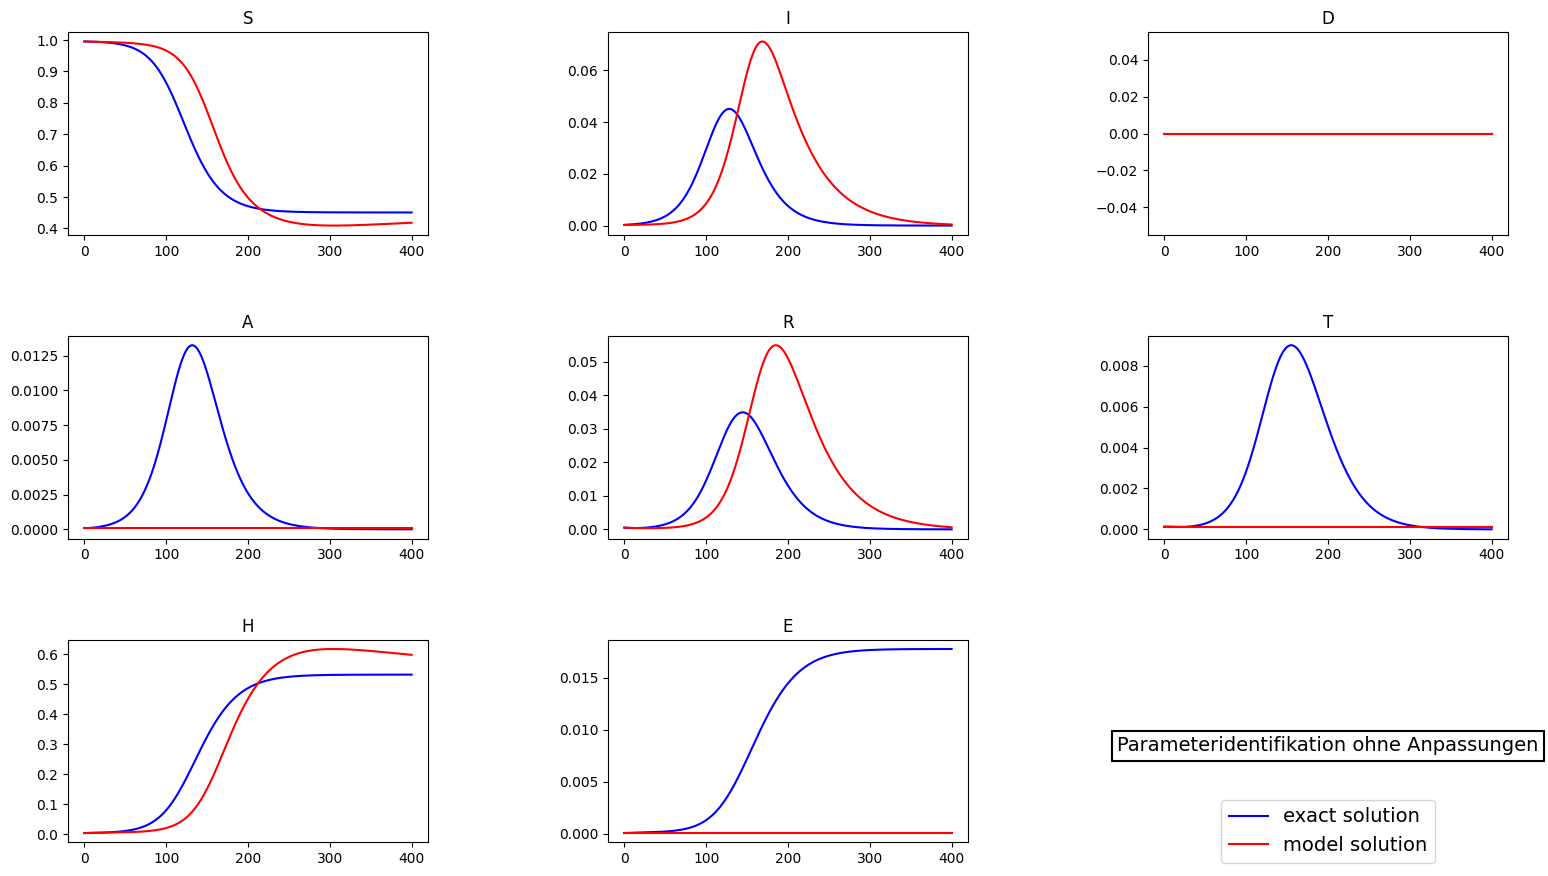

In [3]:
parameters = Parameters8(alpha=0.15, gamma=0.15)
t, y = sidarthe_simulation8(parameters, t_end=400)

model = ps.SINDy(
    # the default method:
    # differentiation_method=ps.FiniteDifference(order=2),
    feature_library=ps.PolynomialLibrary(degree=2, interaction_only=True),
    optimizer=ps.STLSQ(threshold=0.00175),
    feature_names=["S", "I", "D", "A", "R", "T", "H", "E"]
)

model.fit(y, t=t, quiet=True)
model.print()

# SIMULATION
[s0, i0, d0, a0, r0, t0, h0, e0] = parameters.y0
sim = model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t)

# PLOT
plot_all_compare(t, y, sim, text="Parameteridentifikation ohne Anpassungen")

Für alpha=gamma=0.15: Man erkennt schon an den Gleichungen für das Modell, dass die Zustände A,T und E (und D) konstant bleiben. Vermutlich sind die Werte in diesen Zuständen zu klein, sodass SINDy diese Zustände ignoriert (sind andere Ableitungen mit "normierten Werten" möglich? -> Normalisierung beim Optimierer hilft scheinbar auch nicht)

---
Im nächsten Schritt versuchen wir die Ergebnisse durch einen "inital guess" zu verbessern.

In [4]:
parameters = Parameters8()

alpha = parameters.alpha
beta = parameters.beta
gamma = parameters.gamma
epsilon = parameters.epsilon
theta = parameters.theta
zeta = parameters.zeta
my_lambda = parameters.my_lambda
kappa = parameters.kappa
mu = parameters.mu
sigma = parameters.sigma
tau = parameters.tau

exact_initial_guess = np.array([
    [0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  -alpha,
        -beta,  -gamma,  -beta,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  -epsilon-zeta-my_lambda,  0.,  0.,
        0.,  0.,  0.,  0.,  parameters.alpha,
        parameters.beta,  parameters.gamma,  parameters.beta,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  epsilon,  -zeta-my_lambda,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  zeta,  0.,  - (theta + mu + kappa),
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  0.,  zeta,  theta,
        - (mu + kappa),  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  0.,  0.,  mu,
        mu,  - (sigma + tau),  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  my_lambda,  my_lambda,  kappa,
        kappa,  sigma,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  0.,  0.,  0.,
        0.,  tau,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.]])

Die Identifikation funktioniert (wie erwartet) sehr gut mit dem korrekten "initial guess" für die default-Parameter, sogar wenn die Datenpunkte mit veränderten Parametern $\alpha$ und $\gamma$ generiert werden. Außerdem benutze ich hier als optimizer ps.SR3.

Die sogenannte "Sparse relaxed regularized regression"

versucht die Zielfunktion
$ 0.5\|y-Xw\|^2_2 + \lambda \times R(v) + (0.5 / \nu)\|w-v\|^2_2 $
zu minimieren, wobei $R(v)$ eine "Regulierungsfunktion" (regularization function) ist.

### Hier können die Parameter des Systems geändert werden. So kann man ausprobieren, wie sich die Identifikation bei leicht veränderten Parametern verhält.

S' = -0.131 S I + -0.236 S A
I' = -0.108 I + 0.188 S I + -0.113 S A
D' = 0.000
A' = 0.079 I + -0.267 A
R' = 0.198 A + -0.069 R
T' = 0.013 A + 0.013 R + -0.063 T
H' = 0.060 I + 0.053 A + 0.057 R + 0.044 T
E' = 0.019 T


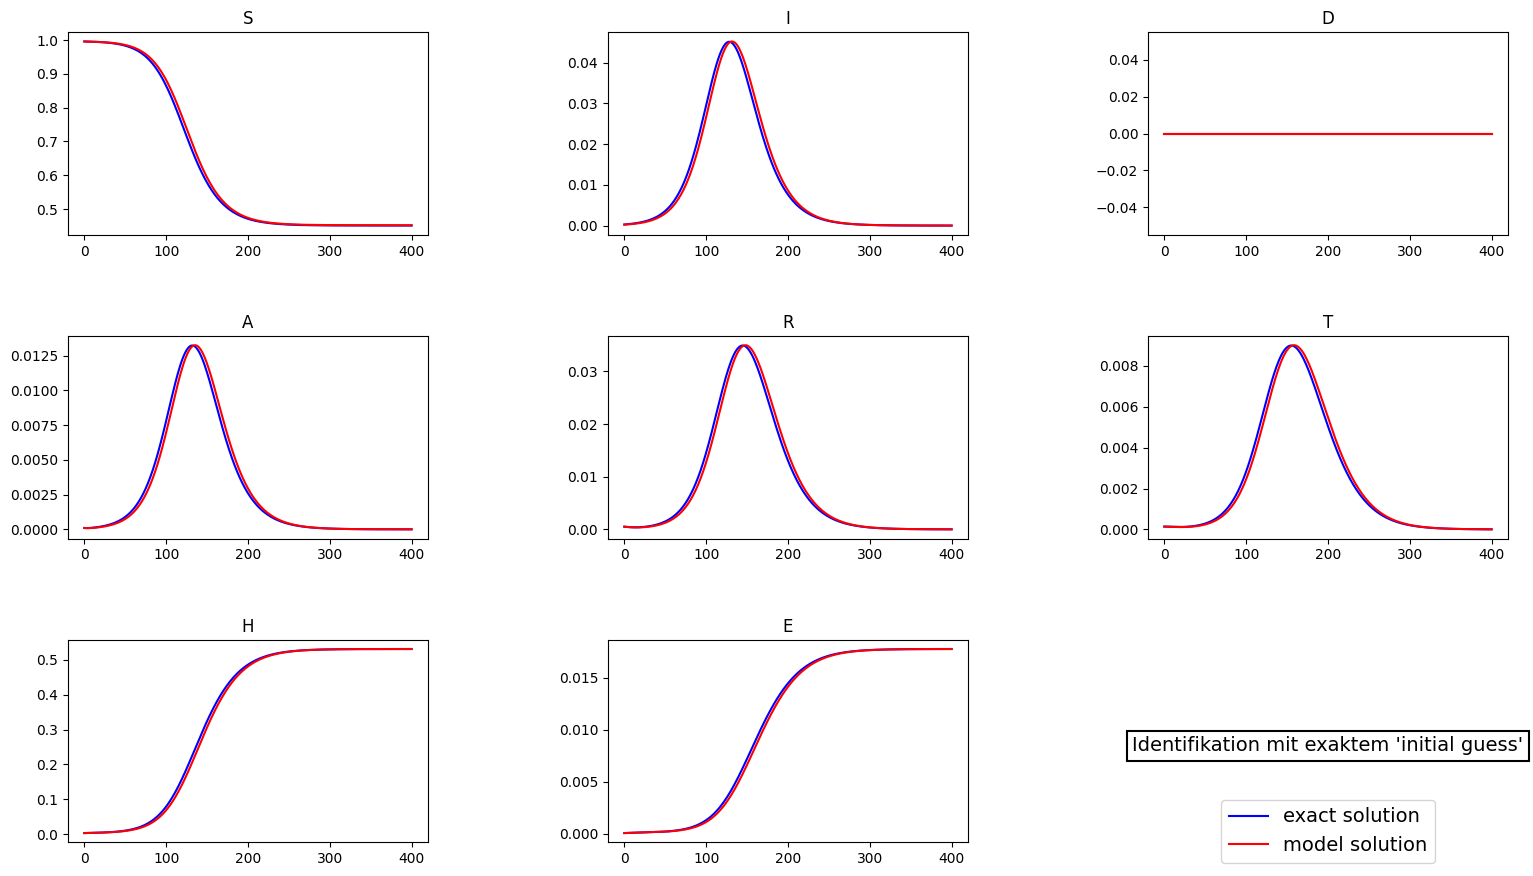

In [5]:
parameters = Parameters8(alpha=0.15, gamma=0.15)
t, y = sidarthe_simulation8(parameters, t_end=400)

model = ps.SINDy(
    # differentiation_method default option is centered difference
    feature_library=ps.PolynomialLibrary(degree=2, interaction_only=True),
    optimizer=ps.SR3(threshold=1e-2, initial_guess=exact_initial_guess,
                     max_iter=30000, normalize=True),
    feature_names=["S", "I", "D", "A", "R", "T", "H", "E"]
)

model.fit(y, t=t)
model.print()

# SIMULATION
[s0, i0, d0, a0, r0, t0, h0, e0] = parameters.y0
sim = model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t)

# PLOT
plot_all_compare(t, y, sim, text="Identifikation mit exaktem 'initial guess'")

In obier Berechnung sieht man, dass der Algorithmus nicht die exakte Lösung gefunden hat, obwohl diese als initial guess angegeben war. Vermutlich hat der Regulationsterm $R(v)$ dafür gesorgt, dass die berechnete Funktion mögllichst sparse (dünn besetzt)
ist. Man kann die gefundenen Gleichungen also als besonders wichtige Terme der exakten Lösung interpretieren. Das sieht man schon anhand guten Approximation der Kurven durch eine weniger besetzte Lösungsmatrix. (Später werden noch die Abweichung der Lösung zum gegebenen Datensatz berechnet, um die Resultate einfacher zu bewerten.)

Ich versuche nochmal das ursprüngliche Problem ohne initial guess und mit veränderten optimizer und/oder integrator zu lösen.

### Anmerkung: 
Dieser Teil ist experimentell und verhält sich bei verschiedenen Versionen von pysindy sehr unterschiedlich. Oft hilft es, die folgende Zelle mehrfach auszuführen, falls die Kurven nicht aufeinander liegen. Außerdem sieht man bei "guten" Parametern nur die rote Kurve (die beiden Kurven sind nahezu identisch). Warnungen können ignoriert werden.

S' = -5075534.448 1 + 5438022.635 S + 55160585.862 I + -0.699 D + -106593138.624 A + 24209045.675 R + 2292128.631 T + 12556746.865 H + 1860428.930 E + 43602.873 S I + 82522549.400 S A + -103383415.577 S R + -60622159.222 S T + -103862142.775 S H + 13959642.174 S E + 11979072.835 I A + 50032363.171 I R + -81600440.465 I T + -5203636.266 I H + 21020069.344 I E + -16452851.677 A R + -18991633.178 A T + 71521917.124 A H + 14457175.503 A E + -10198767.059 R T + -12243983.857 R H + -91721.585 R E + 8642199.124 T H + -62422943.205 T E + -2041504.028 H E
I' = 3551472.856 1 + -3805603.301 S + -38665579.314 I + 0.490 D + 74722988.401 A + -16981757.409 R + -1622929.529 T + -8795999.352 H + -1299193.945 E + -30572.562 S I + -57834767.321 S A + 72492867.064 S R + 42529620.507 S T + 72814781.548 S H + -9795675.062 S E + -8376269.457 I A + -35069921.038 I R + 57324129.221 I T + 3644545.113 I H + -14769866.209 I E + 11538424.988 A R + 13231900.589 A T + -50097365.992 A H + -10110095.910 A E + 7177529.

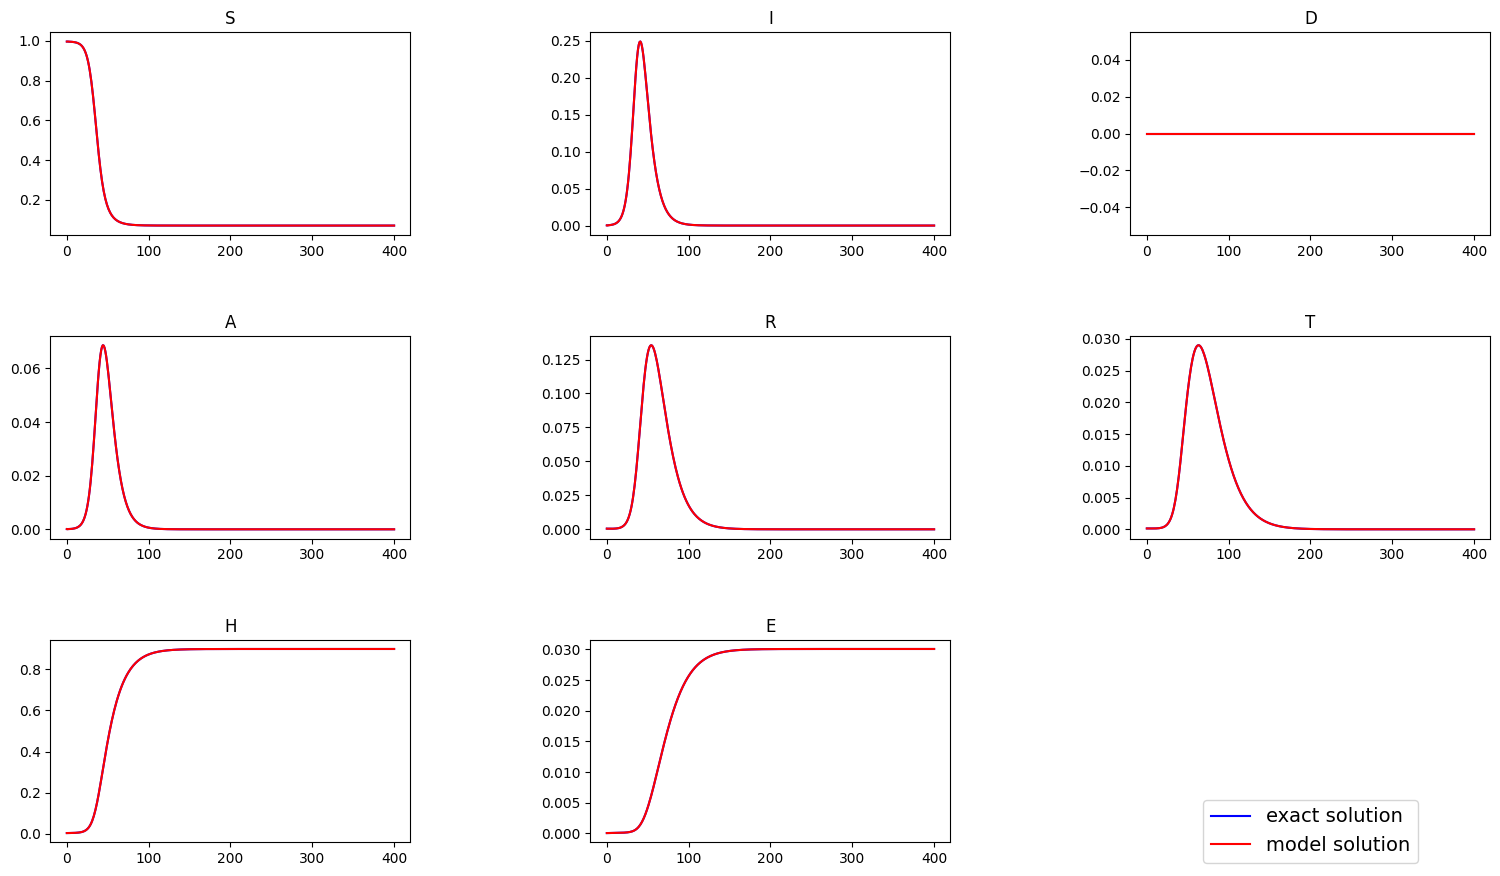

In [6]:
# ACHTUNG! NICHT DETERMINISTISCH!

parameters = Parameters8(alpha=0.3, gamma=0.3)
t, y = sidarthe_simulation8(parameters, t_end=400)

# MODEL FIT
model = ps.SINDy(
    differentiation_method=ps.SINDyDerivative(
        kind='trend_filtered', order=3, alpha=1e-2),
    feature_library=ps.PolynomialLibrary(degree=2, interaction_only=True),
    optimizer=ps.SR3(max_iter=1000, threshold=0.01, normalize=False),
    feature_names=["S", "I", "D", "A", "R", "T", "H", "E"]
)

model.fit(y, t=t, quiet=True)
model.print()

# SIMULATION
[s0, i0, d0, a0, r0, t0, h0, e0] = parameters.y0
sim = model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t)

# PLOT
plot_all_compare(t, y, sim, text="")

Mit der Ableitungsmethode "trend_filtered" (Aus der Dokumentation: Use total squared variations to fit the data (computes a global derivative that is a piecewise combination of polynomials of a chosen order). Set order=0 to obtain the total-variational derivative. Appropriate for noisy data) kann die Funktion gut approximiert werden. Allerdings sind alle Koeffizienten extrem groß und daher sind diese Ergebnisse schwer zu interpretieren.

### Anmerkung
Die Ableitungsmethode "trend_filtered" scheint hier sehr gut zu funktionieren obwohl hier aus nicht gezeigten Berechnungen hervor geht, dass diese Methode sehr schlechte Approximationen an die echten Ableitungen liefert.

---

Im nächsten Schritt versuchen wir die Koeffizienten klein zu halten indem wir zunächst einen perfekten "initial guess" (für alpha=gamma=0.15; der Datensatz ist mit alpha=gamma=0.3 generiert!) angeben und später versuchen wir diesen nicht mehr genau anzugeben (Idee: Intervalle aus Parameterschätzungen aus dem Paper von Allgöwer benutzen und zufällige Werte in den Intervallen als "initial guess" benutzten. Außerdem für jeden benutzten Datensatz die Hyperparameter tunen.)

S' = -0.378 S I
I' = -0.137 I + 0.364 S I
D' = 0.000
A' = 0.084 I + -0.287 A
R' = 0.209 A + -0.073 R
T' = 0.014 A + 0.012 R + -0.062 T
H' = 0.073 I + 0.066 R + 0.027 T
E' = 0.019 T


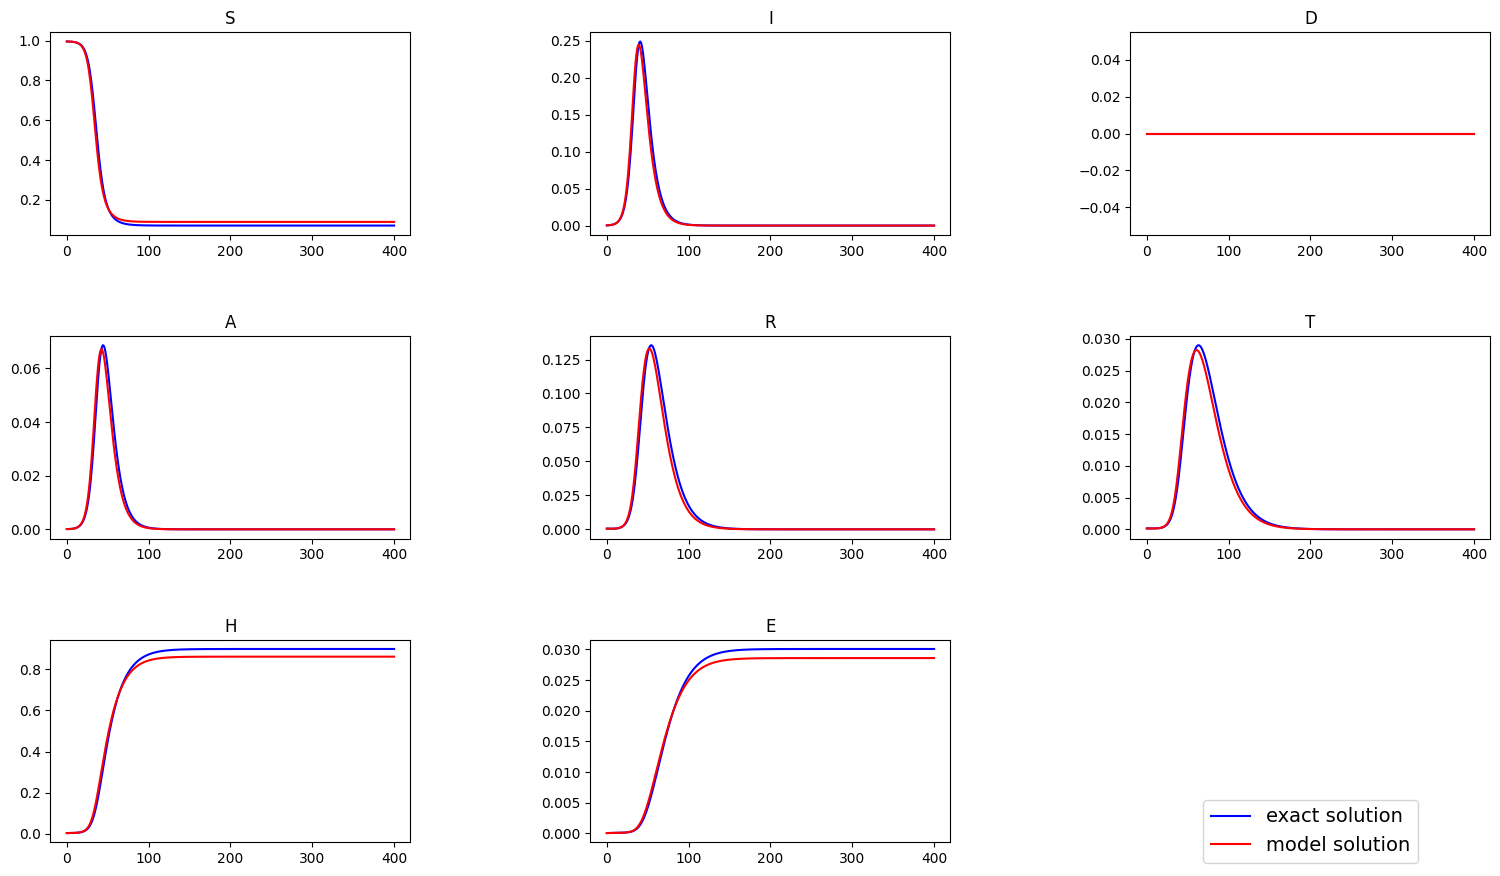

In [7]:
parameters = Parameters8(alpha=0.3, gamma=0.3)
t, y = sidarthe_simulation8(parameters, t_end=400)

# MODEL FIT
model = ps.SINDy(
    differentiation_method=ps.SINDyDerivative(
        kind='trend_filtered', order=0, alpha=1e-2),
    feature_library=ps.PolynomialLibrary(degree=2, interaction_only=True),
    optimizer=ps.SR3(max_iter=10000, threshold=0.01,
                     normalize=False, initial_guess=exact_initial_guess),
    feature_names=["S", "I", "D", "A", "R", "T", "H", "E"]
)

model.fit(y, t=t, quiet=True)
model.print()

# SIMULATION
[s0, i0, d0, a0, r0, t0, h0, e0] = parameters.y0
sim = model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t)

# PLOT
plot_all_compare(t, y, sim, text="")

Des Weiteren schauen wir, wenn wir SINDy nicht den vollständigen Datensatz zur Verfügung stellen, sondern z.B. nur die ersten 50 Zeitschritte:

S' = -0.277 S I + -0.419 S A
I' = -0.116 I + 0.355 S I + -0.146 S A
D' = 0.000
A' = 0.072 I + -0.237 A
R' = 0.169 A + -0.045 R
T' = 0.021 A + -0.008 R + 0.038 T
H' = 0.015 I + 0.529 A + -0.610 R + 3.139 T
E' = 0.014 T


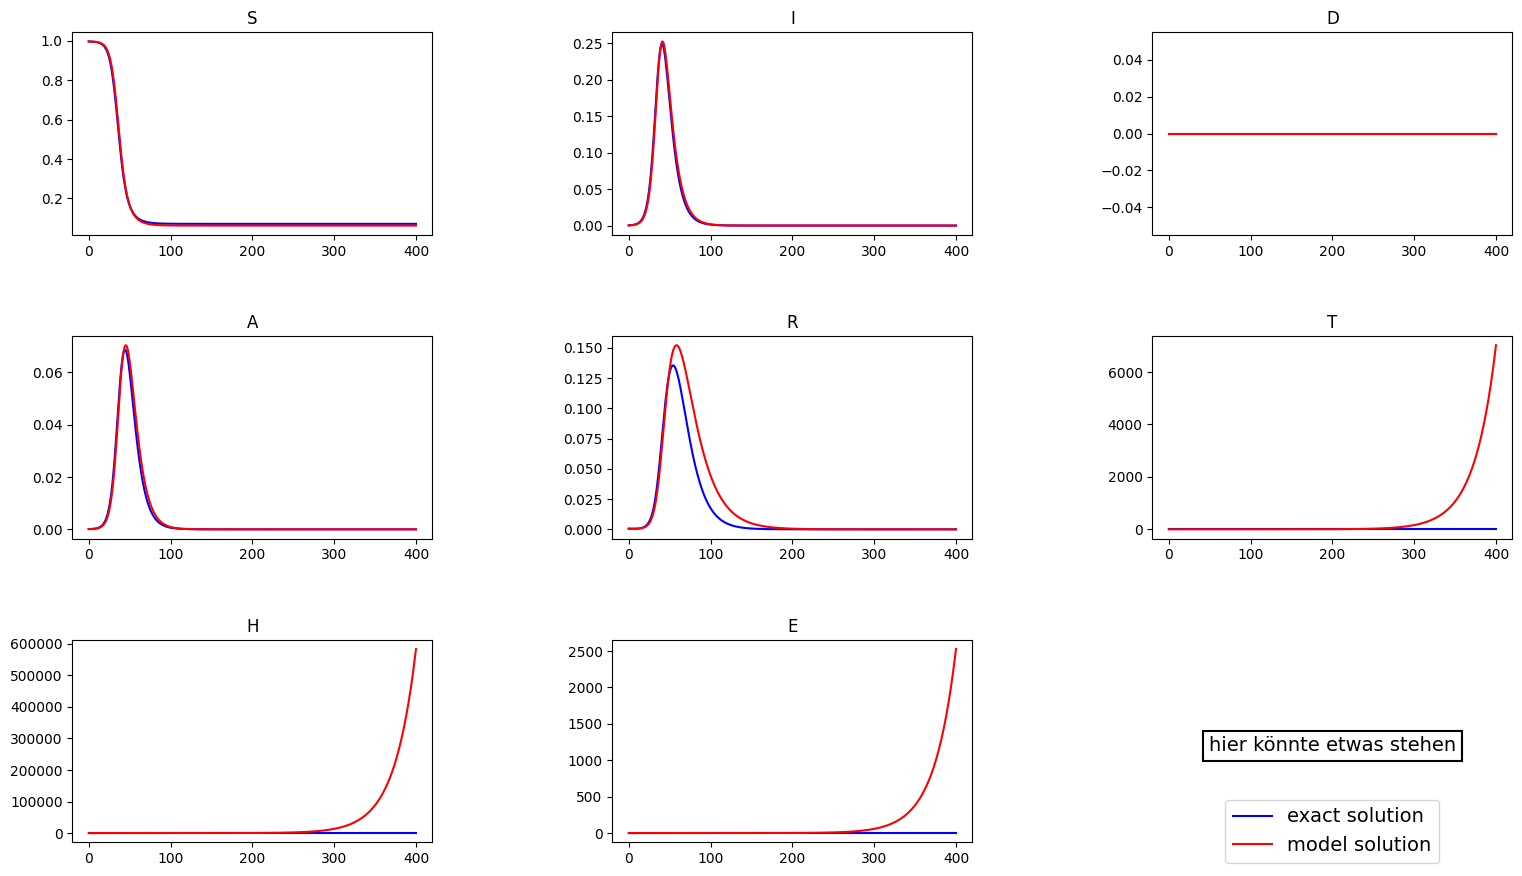

In [8]:
parameters = Parameters8(alpha=0.3, gamma=0.3)
t, y = sidarthe_simulation8(parameters, t_end=400)

# MODEL FIT
model = ps.SINDy(
    differentiation_method=ps.SINDyDerivative(
        kind='trend_filtered', order=0, alpha=1e-2),
    feature_library=ps.PolynomialLibrary(degree=2, interaction_only=True),
    optimizer=ps.SR3(max_iter=1000, threshold=0.01,
                     normalize=False, initial_guess=exact_initial_guess),
    feature_names=["S", "I", "D", "A", "R", "T", "H", "E"]
)

model.fit(y[:50], t=t[:50], quiet=True)
model.print()

# SIMULATION
[s0, i0, d0, a0, r0, t0, h0, e0] = parameters.y0
sim = model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t)

# PLOT
plot_all_compare(t, y, sim)

Im Folgenden möchten wir einen ungenauen initial guess benutzen und dann für unterschiedliche Parameter im System testen. Die Parameter entnehmen wir dem [Paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7757387/) von Allgöwer und wählen dort alpha=alpha1 und gamma=gamma1. Die Werte der Parameter lauten:

$\alpha=0.175771057515159$

$\beta=0.00844384791042575$

$\gamma=0.1757710634027378$

$\epsilon=0$

$\theta=0.1980571066560948$

$\zeta=0.07901877992285243$

$\lambda=0.05961066603689205$

$\kappa=0.056288791238505$

$\mu=0.013025936744049$

$\sigma=0.04406078628710332$

$\tau=0.019087122640751797$

In [9]:
alpha = 0.175771057515159
beta = 0.00844384791042575
gamma = 0.1757710634027378
epsilon = 0
theta = 0.1980571066560948
zeta = 0.07901877992285243
my_lambda = 0.05961066603689205
kappa = 0.056288791238505
mu = 0.013025936744049
sigma = 0.04406078628710332
tau = 0.019087122640751797


allgower_initial_guess = np.array([
    [0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  -alpha,
        -beta,  -gamma,  -beta,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  -epsilon-zeta-my_lambda,  0.,  0.,
        0.,  0.,  0.,  0.,  parameters.alpha,
        parameters.beta,  parameters.gamma,  parameters.beta,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  epsilon,  -zeta-my_lambda,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  zeta,  0.,  - (theta + mu + kappa),
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  0.,  zeta,  theta,
        - (mu + kappa),  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  0.,  0.,  mu,
        mu,  - (sigma + tau),  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  my_lambda,  my_lambda,  kappa,
        kappa,  sigma,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.],
    [0.,  0.,  0.,  0.,  0.,
        0.,  tau,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,
        0.,  0.]])

S' = -0.295 S I + -0.331 S A
I' = -0.138 I + 0.297 S I + 0.313 S A
D' = 0.000
A' = 0.079 I + -0.266 A
R' = 0.198 A + -0.070 R
T' = 0.014 A + 0.011 R + -0.054 T
H' = 0.056 I + 0.080 A + 0.041 R + 0.095 T
E' = 0.019 T


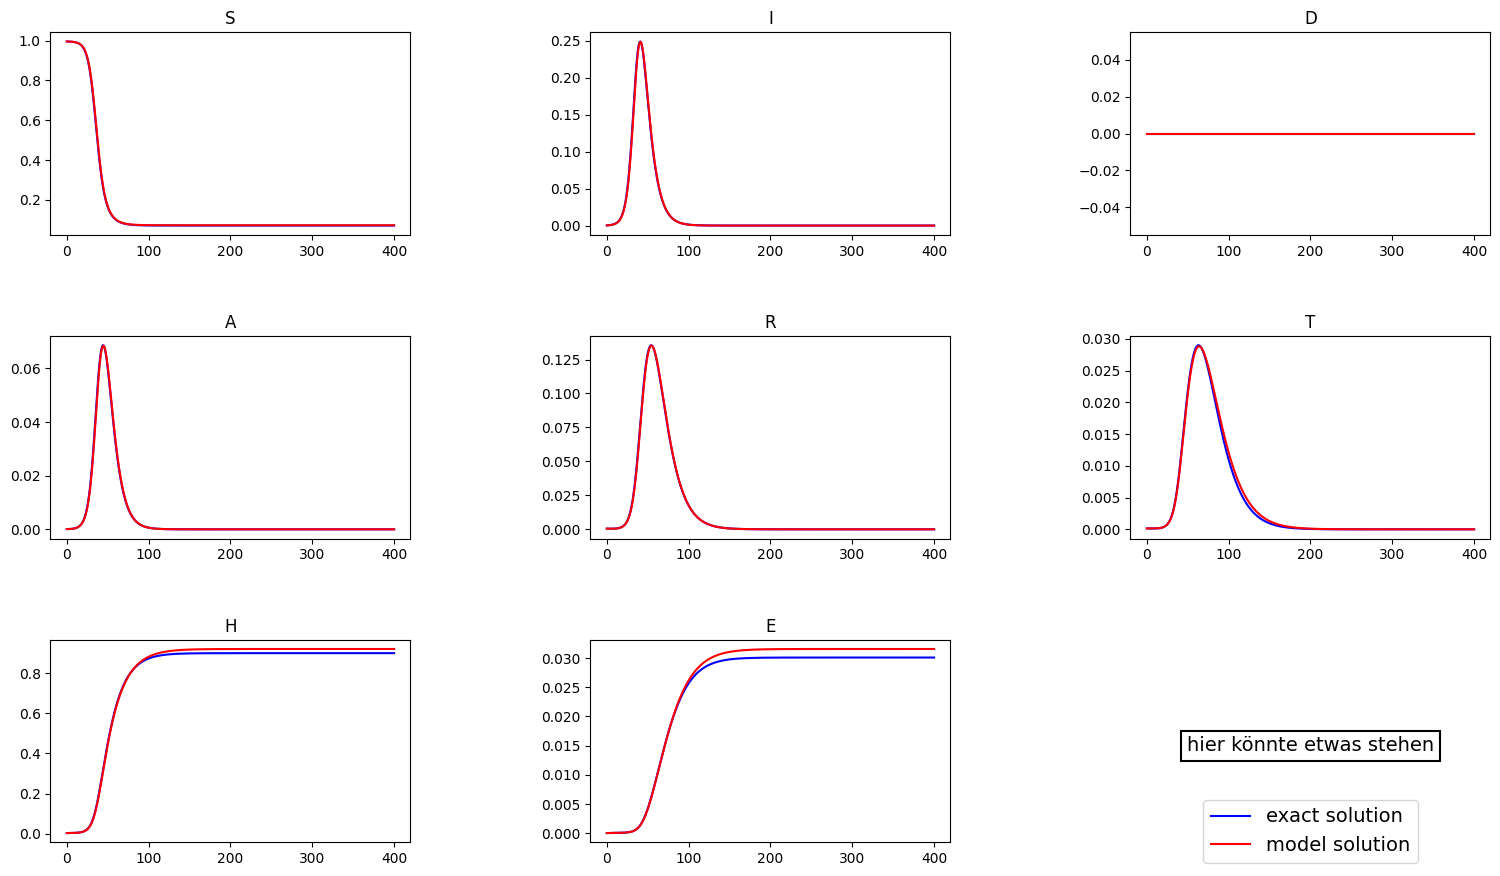

In [10]:
parameters = Parameters8(alpha=0.3, gamma=0.3)
t, y = sidarthe_simulation8(parameters, t_end=400)

# MODEL FIT
model = ps.SINDy(
    differentiation_method=ps.SINDyDerivative(
        kind='trend_filtered', order=0, alpha=1e-2),
    feature_library=ps.PolynomialLibrary(degree=2, interaction_only=True),
    optimizer=ps.SR3(max_iter=10000, threshold=0.01,
                     normalize=False, initial_guess=allgower_initial_guess),
    feature_names=["S", "I", "D", "A", "R", "T", "H", "E"]
)

model.fit(y[:80], t=t[:80])
model.print()

# SIMULATION
[s0, i0, d0, a0, r0, t0, h0, e0] = parameters.y0
sim = model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t)

# PLOT
plot_all_compare(t, y, sim)

Zusammenfassung:

1.Die Ableitungsmethode trend_filtered funktioniert hier am besten.

2.In der feature_library funktionieren Terme vom Grad 2 nur mit Interaktionstermen ausreichend gut, und höhere Grade bringen hier oft keine Verbesserung.

3.Am besten funktioniert der SR3 Optimierer. Die maximalen Iterationen und der optimale threshold hängen stark von dem Trainingsdatensatz (also u.a. von den anfangs gewählten Parametern) ab. Man kann aber problemlos die maximalen Iterationen stark erhöhen, da der Algorithmus nur in wenigen Situationen sehr lange auf die Konvergenz warten muss (und auch bei hohen Iterationen konvergiert der Algorithmus oft nicht; aber praktisch sind die Ergebnisse gut genug)

4.Normalisierung im Optimierer hatte in unseren Tests kaum oder keine Auswirkungen.

5.Auch ohne initial_guess konnten die Kurven gut approximiert werden, allerdings waren die Koeffizienten der DGL sehr groß, sodass eine Interpretation schwierig ist. Außerdem lässt sich das System dann schon bei kleinen Fehlern nicht mehr lange oder garnicht simulieren. Es reicht schon ein ungenauer initial_guess um gut interpretierbare Ergebnisse/Parameter der Differentialgleichung zu erhalten. Ob der initial_guess bezüglich allen Parametern robust ist, muss nocht getestet werden.

6.Mit einem innitial_guess reichen schon die ersten 50 Zeitschritte aus (von den 400 gegebenen) um eine relativ gelungene Vorhersage für den weiteren Verlauf der Kurven zu erhalten. Man könnte hier schauen wie die Simulation für reale Werte funktioniert. Müssen diese aufbereitet werden? Wie kann man SINDy benutzen, wenn nur ein Teil der Daten vorliegt?

---
Aus früheren Resultaten geht hervor, dass das SIDARTHE-System mit den benutzten Anfangswerten für $\alpha = \gamma \approx 0.1015$ und darunter stabil ist. Der folgende Plot zeigt die Parameteridentifikation für diese Parameter.

S' = -0.079 S I + -0.205 S A
I' = -0.491 I + 0.492 S I + 0.011 S A
D' = 0.000
A' = 0.001 I + -0.004 A
R' = 0.148 A + -0.053 R
T' = 0.006 A + 0.013 R + -0.055 T
H' = 0.114 I + -0.067 A + -0.003 R + 0.181 T
E' = 0.019 T


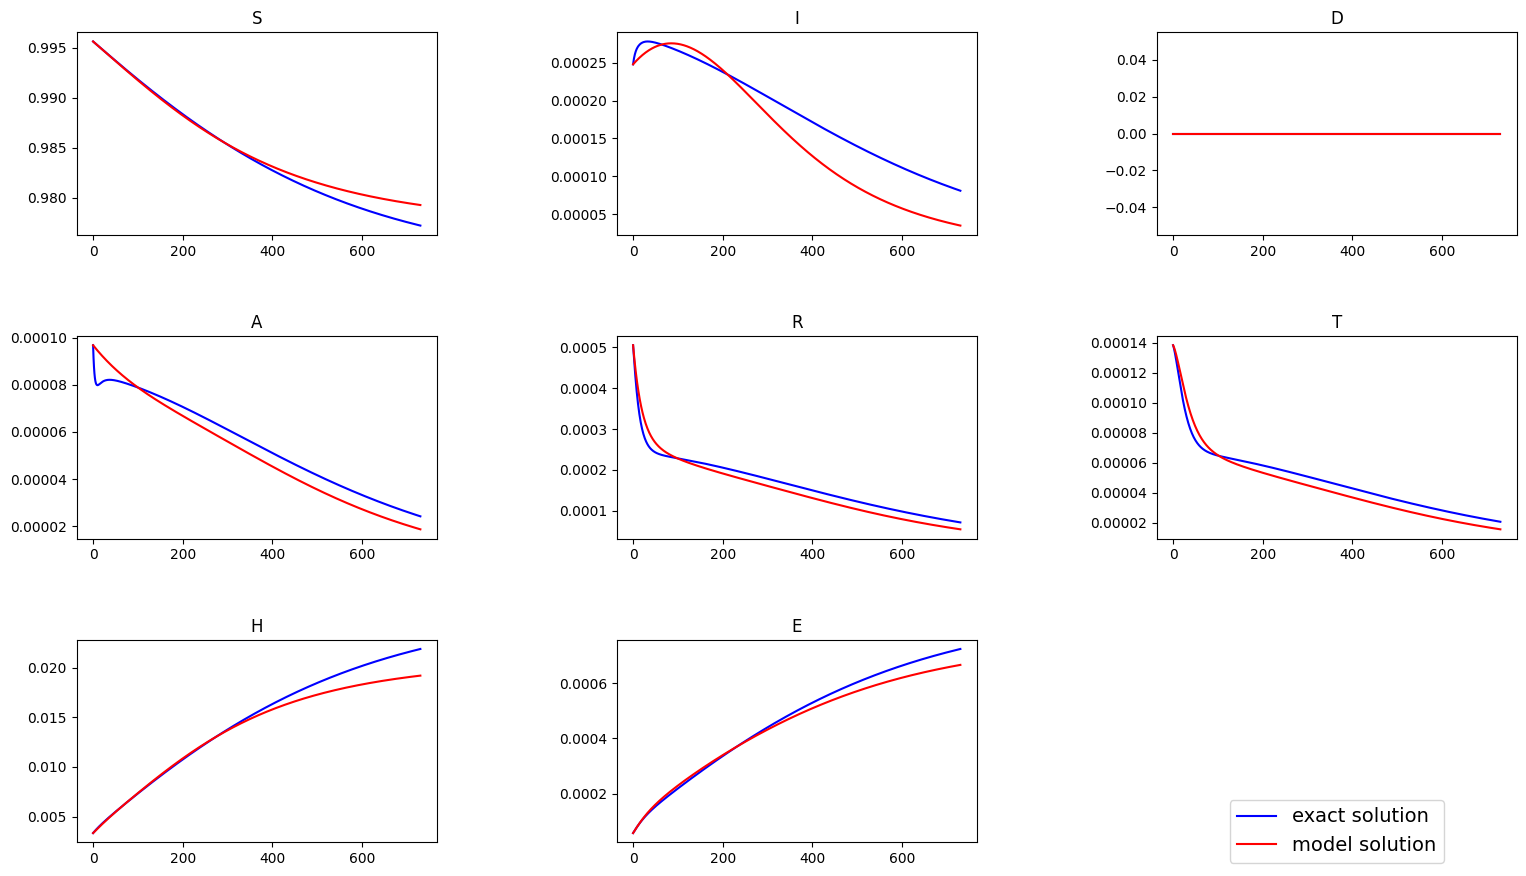

In [11]:
parameters = Parameters8(alpha=0.1015, gamma=0.1015)
t, y = sidarthe_simulation8(parameters, t_end=730)

# MODEL FIT
model = ps.SINDy(
    differentiation_method=ps.SINDyDerivative(
        kind='trend_filtered', order=0, alpha=1e-2),
    feature_library=ps.PolynomialLibrary(degree=2, interaction_only=True),
    optimizer=ps.SR3(max_iter=10000, threshold=0.01,
                     normalize=False, initial_guess=allgower_initial_guess),
    feature_names=["S", "I", "D", "A", "R", "T", "H", "E"]
)

model.fit(y[:200], t=t[:200])
model.print()

# SIMULATION
[s0, i0, d0, a0, r0, t0, h0, e0] = parameters.y0
sim = model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t)

# PLOT
plot_all_compare(t, y, sim, text="")

Der "model score" ist eine Größe zur Interpretation der Identifikationsgüte. Sie liegt zwischen 0 und 1, wobei größere Werte besser sind.

Um automatisch eine möglichst gute Approximation zu berechnen, benutzen wir den Model-Score um das beste Resultat aus verschiedenen Parametern zu erhalten.

In [12]:
model.score(y)

0.486385746256999

### Anmerkung:
Die folgende Zelle kann sehr viele Warnungen erzeugen. Falls diese zu sehr stören sollten diese für diese Session deaktiviert werden.

S' = -0.076 S I + -0.250 S A
I' = -0.123 I + 0.108 S I + 0.085 S A
D' = 0.000
A' = 0.076 I + -0.256 A
R' = 0.192 A + -0.067 R
T' = 0.004 A + 0.020 R + -0.077 T
H' = 0.080 I + 0.010 A + 0.029 R + 0.113 T
E' = 0.019 T


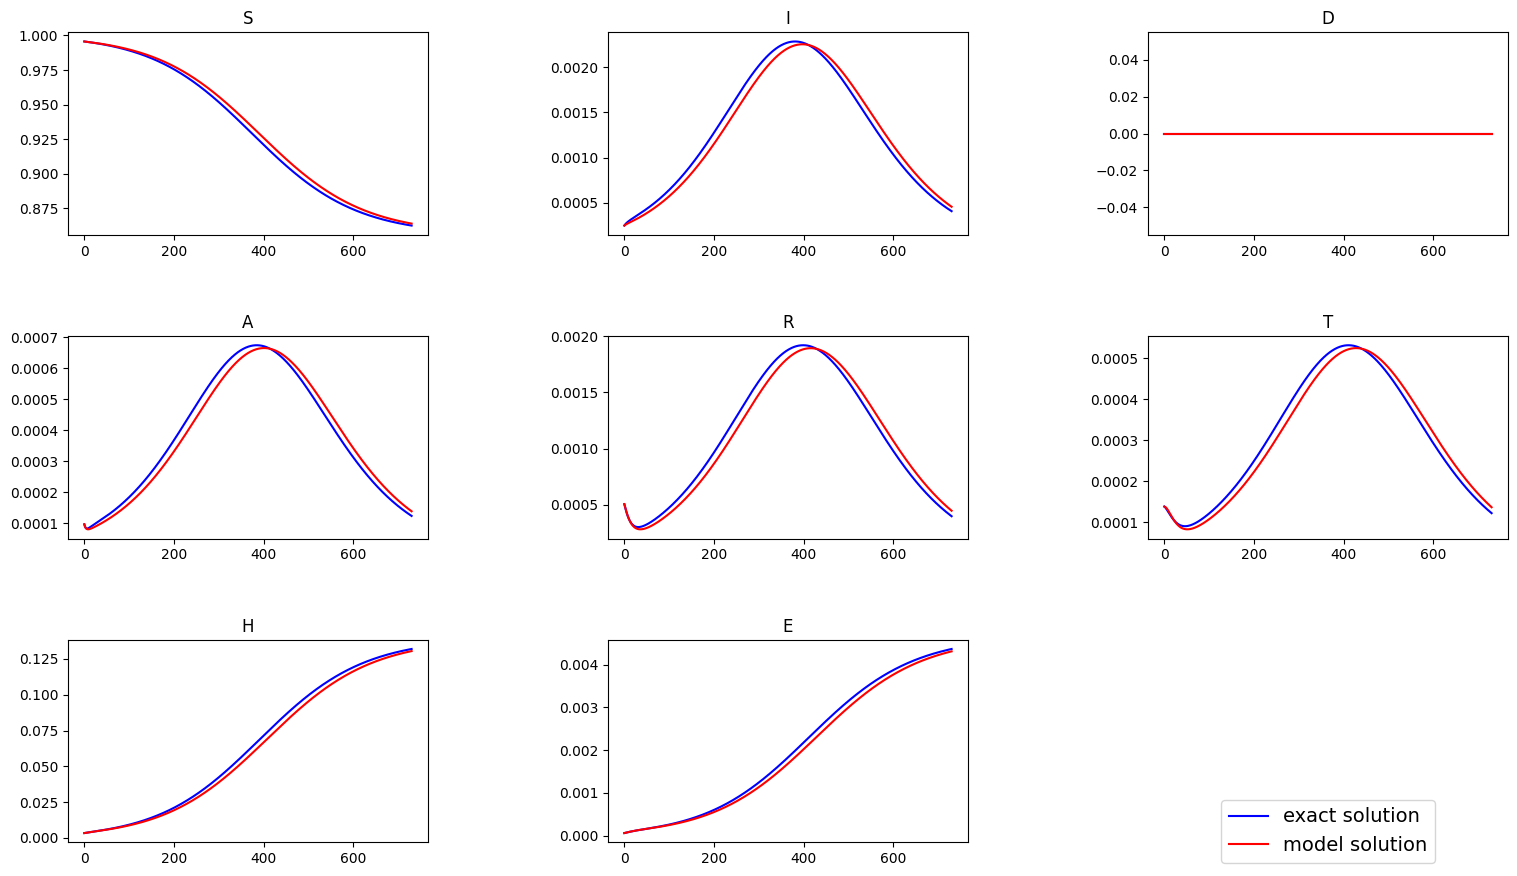

Best threshold is: 0.01
Best modelscore is: 0.013990219357134553


In [13]:
parameters = Parameters8(alpha=0.11, gamma=0.11)
t, y = sidarthe_simulation8(parameters, t_end=730)
[s0, i0, d0, a0, r0, t0, h0, e0] = parameters.y0

thresholds = [0.2, 0.1, 0.05, 0.02, 0.01, 0.0005, 0.002, 0.001]
best_score = 0
best_model = None
for thresh in thresholds:
    for i in range(5):
        # MODEL FIT
        model = ps.SINDy(
            differentiation_method=ps.SINDyDerivative(
                kind='trend_filtered', order=0, alpha=1e-2),
            feature_library=ps.PolynomialLibrary(degree=2, interaction_only=True),
            optimizer=ps.SR3(max_iter=10000, threshold=thresh,
                             normalize=False, initial_guess=allgower_initial_guess),
            feature_names=["S", "I", "D", "A", "R", "T", "H", "E"]
        )
        model.fit(y, t=t, quiet = True)
        error = model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t) - y
        score = (error * error).sum()
        if ((best_model == None) or (score < best_score)):
            best_model = model
            best_thresh = thresh
            best_score = score
            
best_model.print()
# SIMULATION
sim = best_model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t)
# PLOT
plot_all_compare(t, y, sim, text="")
print("Best threshold is:",best_thresh)
print("Best modelscore is:",best_score)

Abschließend wollen wir hier kurt zeigen, wie sich die Identifikation bei verrauschten Daten verhält. Der erste Plot zeigt hier den verrauschten Datensatz.

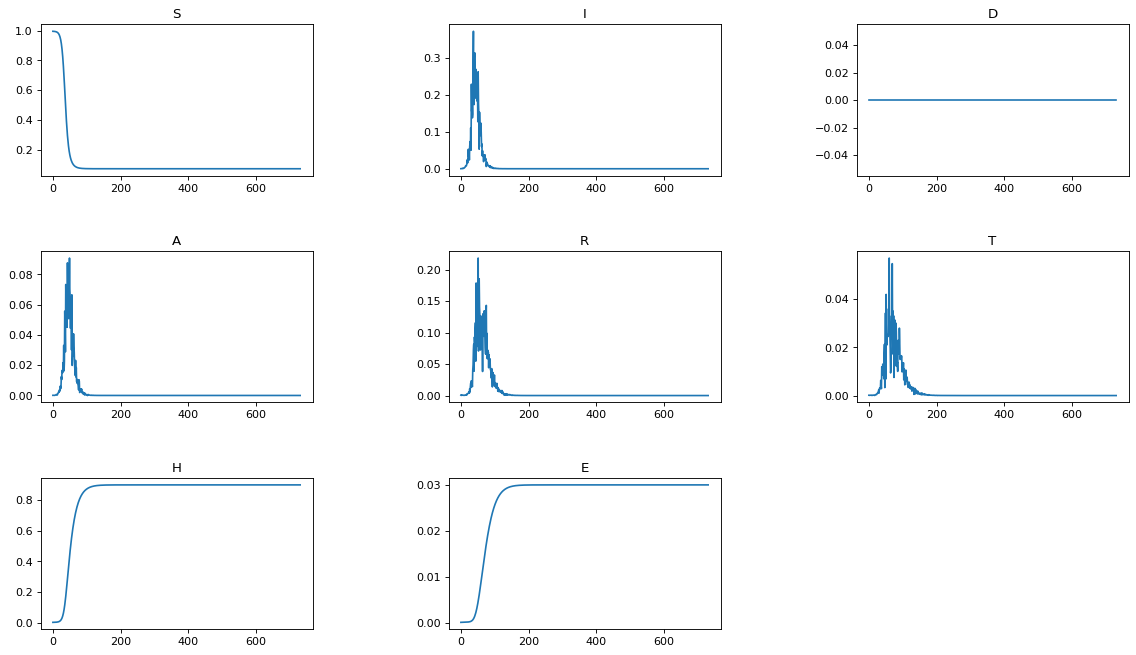

S' = -0.187 S I + -0.775 S A
I' = -0.132 I + 0.279 S I + 0.288 S A
D' = 0.000
A' = 0.018 I + -0.067 A
R' = 0.140 A + -0.047 R
T' = 0.024 A + -0.024 T
H' = 0.046 I + 0.134 A + 0.031 R + 0.062 T
E' = 0.017 T


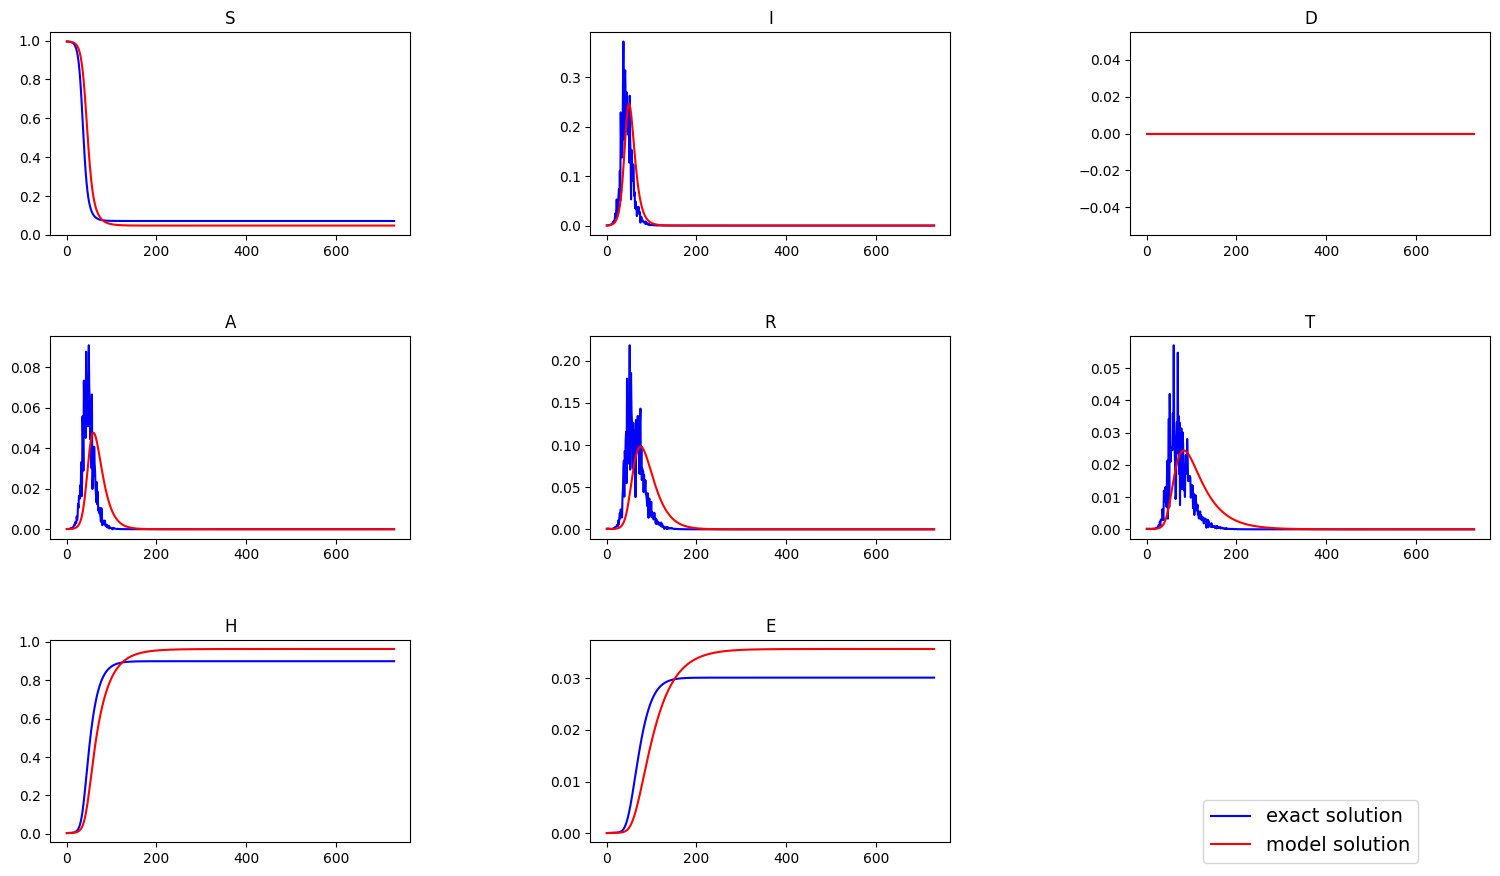

Best threshold is: 0.01
Best modelscore is: 7.117546820956985


In [14]:
parameters = Parameters8(alpha=0.3, gamma=0.3)
t, y = sidarthe_simulation8(parameters, t_end=730)
[s0, i0, d0, a0, r0, t0, h0, e0] = parameters.y0

z = y
z[:, 1:6] = z[:, 1:6] * (1+1/3*np.random.randn(np.shape(y)[0], 5))
plot_all_single_8(t, z)

thresholds = [0.2, 0.1, 0.05, 0.02, 0.01, 0.0005, 0.002, 0.001]
best_score = 0
best_model = None
for thresh in thresholds:
    for i in range(5):
        # MODEL FIT
        model = ps.SINDy(
            differentiation_method=ps.SINDyDerivative(
                kind='trend_filtered', order=0, alpha=1e-2),
            feature_library=ps.PolynomialLibrary(
                degree=2, interaction_only=True),
            optimizer=ps.SR3(max_iter=10000, threshold=thresh,
                             normalize=True, initial_guess=allgower_initial_guess),
            feature_names=["S", "I", "D", "A", "R", "T", "H", "E"]
        )
        model.fit(y, t=t, quiet=True)
        error = model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t) - y
        score = (error * error).sum()
        if ((best_model == None) or (score < best_score)):
            best_model = model
            best_thresh = thresh
            best_score = score

best_model.print()
# SIMULATION
sim = best_model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t)
# PLOT
plot_all_compare(t, y, sim, text="")
print("Best threshold is:", best_thresh)
print("Best modelscore is:", best_score)

Man erkennt eine deutliche Abweichung aber das System wurde in etwa richtig geschätzt.

Hier hat "normalize = True" zu einem sichtbar besserem Ergebnis geführt. Wie schon bei den ersten Beispielen war hier die Ableitungsmethode "trend_filtered" mit "order=0" am besten.

In dem weiterführendem Notebook "SINDy Anpassungen für das SIDARTHE System" wird die benutze "feature library" angepasst. Außerdem werden dort mehrere Parameter optimiert, sodass man für das SIDATHE-System sehr gute Schätzungen erhält.